In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_7528\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_7528\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


### Model Arch

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bridge = self.bridge(self.pool3(d3))

        u3 = self.up3(bridge)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)


In [4]:
model = UNet(12, 1)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)


Total parameters: 7708161
Trainable parameters: 7708161


### Model (6 Bands)

In [5]:
def compute_global_min_max(image_dir, selected_bands):
    images = sorted(os.listdir(image_dir))

    global_min = None
    global_max = None

    for img_name in images:
        img_path = os.path.join(image_dir, img_name)

        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)

        image = image[selected_bands]

        if global_min is None:
            global_min = image.min(axis=(1,2))
            global_max = image.max(axis=(1,2))
        else:
            global_min = np.minimum(global_min, image.min(axis=(1,2)))
            global_max = np.maximum(global_max, image.max(axis=(1,2)))

    return global_min, global_max


selected_bands = [0, 1 , 2 ,3 , 4, 5, 6,7 ,8 ,9 ,10 , 11] 

global_min, global_max = compute_global_min_max(image_dir, selected_bands)

print("Global Min:", global_min)
print("Global Max:", global_max)

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Global Min: [-1.393e+03 -1.169e+03 -7.220e+02 -6.840e+02 -4.120e+02 -3.350e+02
 -2.580e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]
Global Max: [ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  4245.  4287.
   100.   111.]


In [ ]:
selected_bands = [0 ,1 ,4, 5 ,6 ,11]

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands, global_min, global_max):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands
        self.global_min = global_min
        self.global_max = global_max

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(
            self.label_dir,
            os.path.splitext(img_name)[0] + ".png"
        )

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)

        image = image[self.selected_bands] 

        green = image[1]
        nir = image[3]
        ndwi = (green - nir) / (green + nir + 1e-8)

        ndwi = np.expand_dims(ndwi, axis=0)
        # image = np.concatenate([image, ndwi], axis=0)  # (7,H,W)

        for c in range(image.shape[0]):
            min_val = self.global_min[c]
            max_val = self.global_max[c]
            if max_val > min_val:
                image[c] = (image[c] - min_val) / (max_val - min_val)

        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.int64)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

In [7]:
dataset = WaterDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    selected_bands=selected_bands,
    global_min=global_min,
    global_max=global_max
)

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
def dice_loss(outputs, targets, smooth=1e-6):
    """
    outputs: (B,2,H,W) raw logits
    targets: (B,H,W)  int64
    """

    # Convert logits → probabilities
    probs = F.softmax(outputs, dim=1)

    targets_onehot = F.one_hot(targets, num_classes=2)  
    targets_onehot = targets_onehot.permute(0, 3, 1, 2).float()  

    dims = (0, 2, 3)

    intersection = torch.sum(probs * targets_onehot, dims)
    cardinality = torch.sum(probs + targets_onehot, dims)

    dice = (2. * intersection + smooth) / (cardinality + smooth)

    return 1 - dice.mean()

In [24]:
import torch.nn.functional as F
model = UNet(in_channels=6, out_channels=2).to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.3, 0.7]).to(device))
optimizer = optim.Adam(model.parameters(), lr=2e-5 , weight_decay=2e-5)

epochs = 50

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []



In [ ]:
def calculate_metrics(outputs, masks):
    # outputs: (B,2,H,W)
    # masks:   (B,H,W)

    preds = torch.argmax(outputs, dim=1)  

    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = ((preds == 1) & (masks == 1)).sum().float()
    FP = ((preds == 1) & (masks == 0)).sum().float()
    FN = ((preds == 0) & (masks == 1)).sum().float()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return precision.item(), recall.item(), iou.item(), dice.item(), f1.item()


train_losses = []
val_losses = []

for epoch in range(epochs):

    # ================= TRAIN =================
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)

        ce = criterion(outputs, masks)
        d_loss = dice_loss(outputs, masks)

        loss = ce + d_loss  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ================= VALIDATION =================
    model.eval()
    val_loss = 0
    val_precision = 0
    val_recall = 0
    val_iou = 0
    val_dice_metric = 0
    val_f1 = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)

            ce = criterion(outputs, masks)
            d_loss = dice_loss(outputs, masks)

            loss = ce + d_loss
            val_loss += loss.item()

            precision, recall, iou, dice, f1 = calculate_metrics(outputs, masks)
            val_precision += precision
            val_recall += recall
            val_iou += iou
            val_dice_metric += dice
            val_f1 += f1

    val_loss /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice_metric /= len(val_loader)
    val_f1 /= len(val_loader)

    val_losses.append(val_loss)

    print(f"\nEpoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val precision:   {val_precision:.4f}")
    print(f"Val recall:   {val_recall:.4f}")
    print(f"Val IoU:    {val_iou:.4f}")
    print(f"Val f1:   {val_f1:.4f}")



100%|██████████| 17/17 [00:06<00:00,  2.55it/s]



Epoch [1/50]
Train Loss: 0.9716
Val Loss:   1.2014
Val precision:   0.3303
Val recall:   0.0036
Val IoU:    0.0035
Val f1:   0.0071


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]



Epoch [2/50]
Train Loss: 0.7940
Val Loss:   1.1014
Val precision:   0.9462
Val recall:   0.0324
Val IoU:    0.0323
Val f1:   0.0626


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]



Epoch [3/50]
Train Loss: 0.7338
Val Loss:   0.9235
Val precision:   0.9198
Val recall:   0.5291
Val IoU:    0.5053
Val f1:   0.6705


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]



Epoch [4/50]
Train Loss: 0.6803
Val Loss:   0.7223
Val precision:   0.8097
Val recall:   0.6729
Val IoU:    0.5811
Val f1:   0.7339


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]



Epoch [5/50]
Train Loss: 0.6702
Val Loss:   0.6655
Val precision:   0.7690
Val recall:   0.7081
Val IoU:    0.5846
Val f1:   0.7368


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]



Epoch [6/50]
Train Loss: 0.6347
Val Loss:   0.6892
Val precision:   0.6944
Val recall:   0.8019
Val IoU:    0.5931
Val f1:   0.7439


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]



Epoch [7/50]
Train Loss: 0.6122
Val Loss:   0.6371
Val precision:   0.7044
Val recall:   0.8322
Val IoU:    0.6167
Val f1:   0.7626


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]



Epoch [8/50]
Train Loss: 0.6312
Val Loss:   0.6039
Val precision:   0.7948
Val recall:   0.7320
Val IoU:    0.6154
Val f1:   0.7615


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]



Epoch [9/50]
Train Loss: 0.5956
Val Loss:   0.6471
Val precision:   0.6632
Val recall:   0.8724
Val IoU:    0.6045
Val f1:   0.7533


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]



Epoch [10/50]
Train Loss: 0.5372
Val Loss:   0.6047
Val precision:   0.7794
Val recall:   0.7780
Val IoU:    0.6354
Val f1:   0.7770


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]



Epoch [11/50]
Train Loss: 0.5420
Val Loss:   0.6291
Val precision:   0.6472
Val recall:   0.8935
Val IoU:    0.6006
Val f1:   0.7502


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]



Epoch [12/50]
Train Loss: 0.5269
Val Loss:   0.5915
Val precision:   0.7780
Val recall:   0.7828
Val IoU:    0.6396
Val f1:   0.7799


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]



Epoch [13/50]
Train Loss: 0.5466
Val Loss:   0.5835
Val precision:   0.7776
Val recall:   0.8243
Val IoU:    0.6656
Val f1:   0.7991


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]



Epoch [14/50]
Train Loss: 0.5308
Val Loss:   0.5491
Val precision:   0.7508
Val recall:   0.8567
Val IoU:    0.6670
Val f1:   0.8001


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]



Epoch [15/50]
Train Loss: 0.5188
Val Loss:   0.5343
Val precision:   0.7507
Val recall:   0.8556
Val IoU:    0.6663
Val f1:   0.7995


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]



Epoch [16/50]
Train Loss: 0.5105
Val Loss:   0.5764
Val precision:   0.6940
Val recall:   0.9011
Val IoU:    0.6441
Val f1:   0.7834


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]



Epoch [17/50]
Train Loss: 0.4689
Val Loss:   0.5359
Val precision:   0.7342
Val recall:   0.8932
Val IoU:    0.6748
Val f1:   0.8056


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]



Epoch [18/50]
Train Loss: 0.4777
Val Loss:   0.5239
Val precision:   0.8159
Val recall:   0.8474
Val IoU:    0.7115
Val f1:   0.8313


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]



Epoch [19/50]
Train Loss: 0.4962
Val Loss:   0.5372
Val precision:   0.7540
Val recall:   0.8839
Val IoU:    0.6859
Val f1:   0.8137


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]



Epoch [20/50]
Train Loss: 0.4682
Val Loss:   0.5219
Val precision:   0.8185
Val recall:   0.8248
Val IoU:    0.6958
Val f1:   0.8204


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]



Epoch [21/50]
Train Loss: 0.4628
Val Loss:   0.5057
Val precision:   0.8004
Val recall:   0.8479
Val IoU:    0.6992
Val f1:   0.8227


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]



Epoch [22/50]
Train Loss: 0.4541
Val Loss:   0.5046
Val precision:   0.7800
Val recall:   0.8801
Val IoU:    0.7037
Val f1:   0.8259


100%|██████████| 17/17 [00:05<00:00,  3.35it/s]



Epoch [23/50]
Train Loss: 0.4272
Val Loss:   0.4981
Val precision:   0.7655
Val recall:   0.9017
Val IoU:    0.7054
Val f1:   0.8272


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]



Epoch [24/50]
Train Loss: 0.4321
Val Loss:   0.4956
Val precision:   0.7987
Val recall:   0.8732
Val IoU:    0.7145
Val f1:   0.8334


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]



Epoch [25/50]
Train Loss: 0.4422
Val Loss:   0.4733
Val precision:   0.8171
Val recall:   0.8697
Val IoU:    0.7269
Val f1:   0.8418


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]



Epoch [26/50]
Train Loss: 0.4147
Val Loss:   0.4857
Val precision:   0.7742
Val recall:   0.8971
Val IoU:    0.7108
Val f1:   0.8308


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]



Epoch [27/50]
Train Loss: 0.4226
Val Loss:   0.5399
Val precision:   0.6924
Val recall:   0.9440
Val IoU:    0.6649
Val f1:   0.7987


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]



Epoch [28/50]
Train Loss: 0.4001
Val Loss:   0.5548
Val precision:   0.6914
Val recall:   0.9351
Val IoU:    0.6596
Val f1:   0.7949


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]



Epoch [29/50]
Train Loss: 0.4047
Val Loss:   0.4632
Val precision:   0.8246
Val recall:   0.8702
Val IoU:    0.7333
Val f1:   0.8461


100%|██████████| 17/17 [00:04<00:00,  3.40it/s]



Epoch [30/50]
Train Loss: 0.4066
Val Loss:   0.4465
Val precision:   0.8050
Val recall:   0.9048
Val IoU:    0.7420
Val f1:   0.8519


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]



Epoch [31/50]
Train Loss: 0.3935
Val Loss:   0.4402
Val precision:   0.8545
Val recall:   0.8537
Val IoU:    0.7451
Val f1:   0.8539


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]



Epoch [32/50]
Train Loss: 0.3816
Val Loss:   0.4527
Val precision:   0.8655
Val recall:   0.8382
Val IoU:    0.7405
Val f1:   0.8509


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]



Epoch [33/50]
Train Loss: 0.3575
Val Loss:   0.4246
Val precision:   0.8303
Val recall:   0.8911
Val IoU:    0.7532
Val f1:   0.8592


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]



Epoch [34/50]
Train Loss: 0.3566
Val Loss:   0.4382
Val precision:   0.8286
Val recall:   0.8844
Val IoU:    0.7475
Val f1:   0.8553


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]



Epoch [35/50]
Train Loss: 0.3664
Val Loss:   0.4356
Val precision:   0.7898
Val recall:   0.9242
Val IoU:    0.7414
Val f1:   0.8515


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]



Epoch [36/50]
Train Loss: 0.3651
Val Loss:   0.4470
Val precision:   0.7588
Val recall:   0.9393
Val IoU:    0.7230
Val f1:   0.8392


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]



Epoch [37/50]
Train Loss: 0.3588
Val Loss:   0.4378
Val precision:   0.8041
Val recall:   0.9145
Val IoU:    0.7472
Val f1:   0.8552


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]



Epoch [38/50]
Train Loss: 0.3420
Val Loss:   0.4080
Val precision:   0.8375
Val recall:   0.8899
Val IoU:    0.7580
Val f1:   0.8622


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]



Epoch [39/50]
Train Loss: 0.3443
Val Loss:   0.4131
Val precision:   0.8329
Val recall:   0.9073
Val IoU:    0.7675
Val f1:   0.8685


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]



Epoch [40/50]
Train Loss: 0.3193
Val Loss:   0.4172
Val precision:   0.8425
Val recall:   0.8823
Val IoU:    0.7573
Val f1:   0.8618


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]



Epoch [41/50]
Train Loss: 0.3350
Val Loss:   0.4025
Val precision:   0.8478
Val recall:   0.8947
Val IoU:    0.7709
Val f1:   0.8706


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]



Epoch [42/50]
Train Loss: 0.3234
Val Loss:   0.4127
Val precision:   0.8253
Val recall:   0.9003
Val IoU:    0.7561
Val f1:   0.8611


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]



Epoch [43/50]
Train Loss: 0.3295
Val Loss:   0.4351
Val precision:   0.7851
Val recall:   0.9323
Val IoU:    0.7426
Val f1:   0.8522


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]



Epoch [44/50]
Train Loss: 0.3174
Val Loss:   0.4040
Val precision:   0.8614
Val recall:   0.8758
Val IoU:    0.7675
Val f1:   0.8684


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]



Epoch [45/50]
Train Loss: 0.3162
Val Loss:   0.4996
Val precision:   0.9368
Val recall:   0.7189
Val IoU:    0.6861
Val f1:   0.8135


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]



Epoch [46/50]
Train Loss: 0.3712
Val Loss:   0.3877
Val precision:   0.8493
Val recall:   0.8829
Val IoU:    0.7629
Val f1:   0.8654


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]



Epoch [47/50]
Train Loss: 0.3453
Val Loss:   0.4730
Val precision:   0.7198
Val recall:   0.9419
Val IoU:    0.6881
Val f1:   0.8150


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]



Epoch [48/50]
Train Loss: 0.3355
Val Loss:   0.4085
Val precision:   0.7999
Val recall:   0.9208
Val IoU:    0.7478
Val f1:   0.8557


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]



Epoch [49/50]
Train Loss: 0.3123
Val Loss:   0.4049
Val precision:   0.8397
Val recall:   0.8954
Val IoU:    0.7643
Val f1:   0.8664


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]



Epoch [50/50]
Train Loss: 0.3128
Val Loss:   0.3991
Val precision:   0.8128
Val recall:   0.9257
Val IoU:    0.7629
Val f1:   0.8654


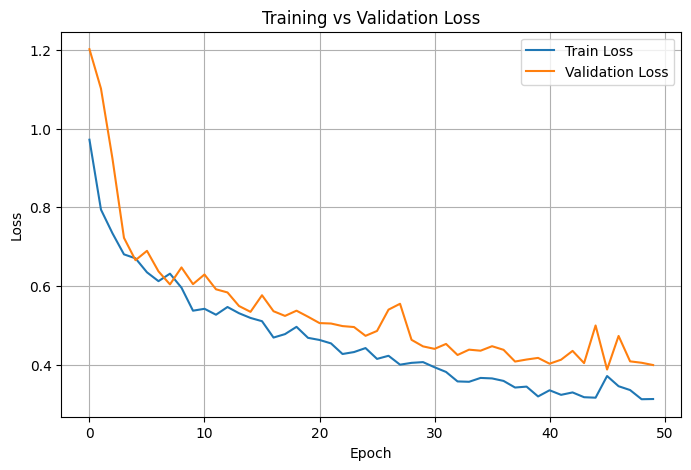

In [27]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


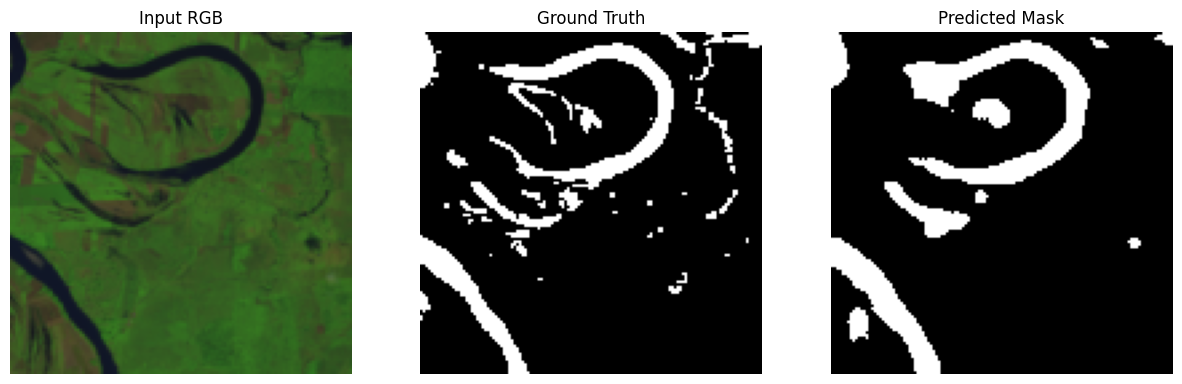

In [ ]:
model.eval()

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0]
pred = preds[0]

if gt.dim() == 3:
    gt = gt.squeeze(0)

if pred.dim() == 3:
    pred = pred.squeeze(0)

if img.shape[0] >= 3:
    rgb = torch.stack([img[3], img[2], img[1]], dim=0)
    rgb = rgb.permute(1, 2, 0)
else:
    rgb = img.permute(1, 2, 0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

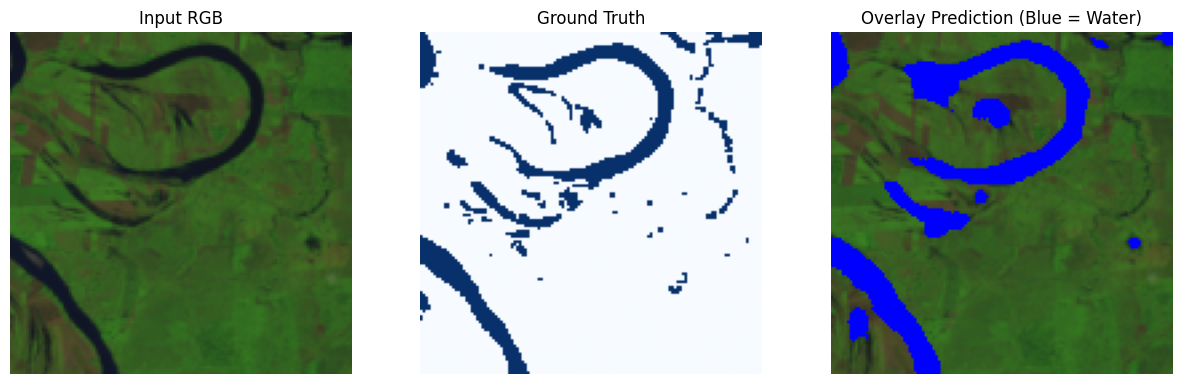

In [29]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Updates 

In [ ]:
## we need to make the min-max norm to the whole dataset not on a sample image ✅
## work with dice loss ✅
## pretrained model deeplab ✅  , Huggingface ✅ , segmentation with pytorch 
## min-max ✅
